In [53]:
from itertools import combinations,chain,product
from pyleoclim.utils import tsutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [54]:
plt.show()

In [55]:
trend = ['No','Linear','Non_Linear']
freq = ['Constant','Two_Constant','Two_Close','Variant']
method = ['linear','cubic']
delete_perc = [0.2,0.4,0.6,0.8]
snr = [0,0.25,0.5,1,2,4,5]

In [56]:
def generate_signal(kind):
    series = pd.Series()
    if (kind == 'Constant'):
        time = np.arange(2001)
        f = 1/50
        signal = np.cos(2*np.pi*f*time)

        series = pd.Series(signal, index=time)
    
    elif kind =='Two_Constant':
        time1 = np.arange(1000)
        f1 = 1/50
        signal1 = np.cos(2*np.pi*f1*time1)

        time2 = np.arange(1000, 2001)
        f2 = 1/100
        signal2 = np.cos(2*np.pi*f2*time2)

        signal = np.concatenate([signal1, signal2])
        time = np.concatenate([time1, time2])

        series = pd.Series(signal, index=time)
    
    elif kind == 'Two_Close':
        time1 = np.arange(1000)
        f1 = 1/50
        signal1 = np.cos(2*np.pi*f1*time1)

        time2 = np.arange(1000, 2001)
        f2 = 1/55
        signal2 = np.cos(2*np.pi*f2*time2)

        signal = np.concatenate([signal1, signal2])
        time = np.concatenate([time1, time2])

        series = pd.Series(signal, index=time)
        return series
    
    elif kind == 'Variant':
        time = np.arange(2001)
        f = 1/100000*(time+1)
        signal = np.cos(2*np.pi*f*time)
        series = pd.Series(signal, index=time)


        
        
    return series
    
    

In [57]:
def add_trend(signal,kind):
    time = signal.index
    trend = 0
    if (kind=='linear'):
        slope = 0.01
        intercept = -1
        trend = slope*time + intercept
    else:
        slope = 1e-5
        intercept = -1
        trend = slope*time**2 + intercept
    
    signal+= trend
    return signal
        
        
    

In [58]:
def delete_points(signal,del_percent):
    time = signal.index
   
    n_del = math.floor(del_percent*np.size(time))
    deleted_idx = np.random.choice(range(np.size(time)), n_del, replace=False)
        
    signal_unevenly =  np.delete(signal.values, deleted_idx)
    time = np.delete(time,deleted_idx)
    
    series = pd.Series(signal_unevenly,index=time)
    return series
        
    
    

In [59]:
def add_white_noise (signal,snr):
    np.random.seed(2333)
    time = signal.index
    sig_var = np.var(signal)
    noise_var = sig_var/snr
    white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
    signal_noise = signal + white_noise
    series = pd.Series(signal_noise, index=time)
    return series

In [60]:
diff_combinations = list(product(freq,trend,delete_perc,snr,method))

In [10]:
result = pd.DataFrame(columns=['Method','Frequency','Deleted Percent','Trend','White Noise','RMSE'])
for value in diff_combinations:
    freq,trend,del_perc,snr,method = value
    
    signal = generate_signal(freq)
    if trend  != 'No':
        signal = add_trend(signal,trend)
    if snr!=0:
        signal = add_white_noise(signal,snr)
    
    uneven_signal = delete_points(signal,del_perc)
    reconstructed_signal = tsutils.interp(uneven_signal.index,uneven_signal,interp_step=1,start = signal.index[0],
                                                    end=signal.index[-1]+1,interp_type=method,fill_value='extrapolate')
    reconstructed_signal = pd.Series(reconstructed_signal[1],index = reconstructed_signal[0])
   
    
    rmse = np.sqrt(mean_squared_error(reconstructed_signal,signal))
    temp = [method,freq,del_perc,trend,snr,rmse]
    result.loc[len(result.index)+1] = temp
    result.append(temp,ignore_index=True)
    
    
    


In [11]:
result.head()

,Method,Frequency,Deleted Percent,Trend,White Noise,RMSE
1,linear,Constant,0.2,No,0,0.004028
2,cubic,Constant,0.2,No,0,0.000030
3,linear,Constant,0.2,No,0.25,0.805397
4,cubic,Constant,0.2,No,0.25,1.073597
5,linear,Constant,0.2,No,0.5,0.569628


In [12]:
rmse_diff = result.loc[result['Method']=='cubic']['RMSE'].values - result.loc[result['Method']=='linear']['RMSE'].values

In [14]:
max(rmse_diff)

20.22498095592602

In [15]:
min(rmse_diff)

-0.17245270078008507

In [16]:
np.mean(rmse_diff)

3.1900239829777557

In [17]:
np.median(rmse_diff)

1.6156702881980385

In [18]:
np.quantile(rmse_diff,0.25)

0.18249563906996372

In [19]:
df =result[['Frequency', 'Deleted Percent','Trend','White Noise']]

In [20]:
df =df.drop_duplicates()

In [21]:
df.reset_index(inplace=True,drop=True)

In [22]:
df

,Frequency,Deleted Percent,Trend,White Noise
0,Constant,0.2,No,0
1,Constant,0.2,No,0.25
2,Constant,0.2,No,0.5
3,Constant,0.2,No,1
4,Constant,0.2,No,2
...,...,...,...,...
331,Variant,0.8,Non_Linear,0.5
332,Variant,0.8,Non_Linear,1
333,Variant,0.8,Non_Linear,2
334,Variant,0.8,Non_Linear,4


In [23]:
df['RMSE_diff'] = rmse_diff

In [24]:
distinct_freq_values = df['Frequency'].unique()

In [25]:
df

,Frequency,Deleted Percent,Trend,White Noise,RMSE_diff
0,Constant,0.2,No,0,-0.003998
1,Constant,0.2,No,0.25,0.268200
2,Constant,0.2,No,0.5,0.189518
3,Constant,0.2,No,1,0.133877
4,Constant,0.2,No,2,0.094527
...,...,...,...,...,...
331,Variant,0.8,Non_Linear,0.5,14.244495
332,Variant,0.8,Non_Linear,1,10.072880
333,Variant,0.8,Non_Linear,2,7.122670
334,Variant,0.8,Non_Linear,4,5.035941


In [26]:
freq_values = df['Frequency'].unique()

In [27]:
freq_values

array(['Constant', 'Two_Constant', 'Two_Close', 'Variant'], dtype=object)

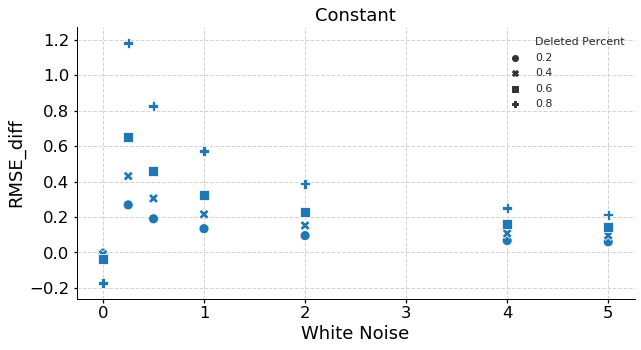

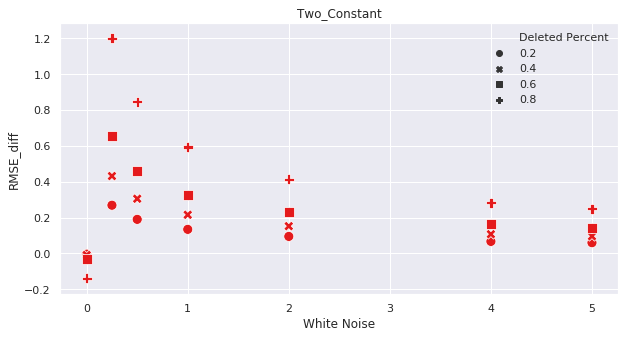

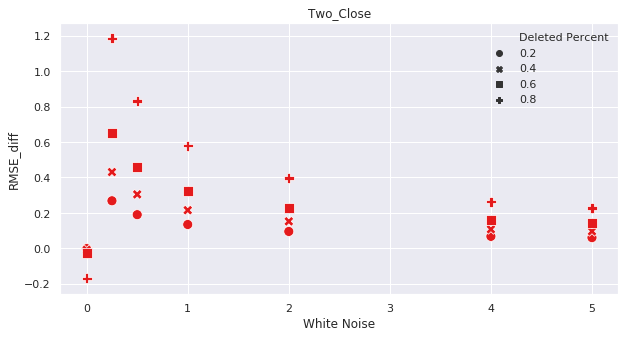

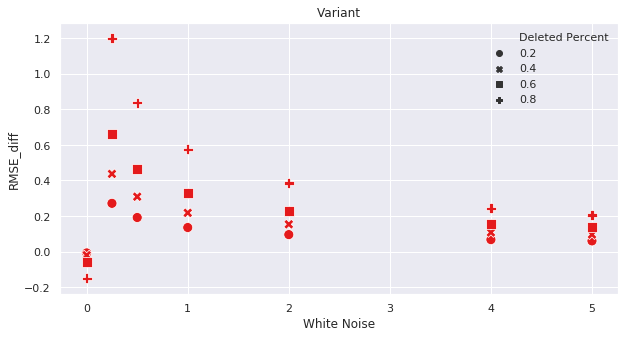

In [28]:
for freq in freq_values:
    df_freq = df.loc[df['Frequency']==freq][df['Trend']=='No']
    plt.figure(figsize=(10,5))
    plt.title(freq)
    sns.set(style="darkgrid")
    sns.set_palette("Set1",3)
    plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    
    sns.scatterplot(x='White Noise',y='RMSE_diff',data=df_freq,s=100,cmap='Accent',style='Deleted Percent')
    

# Binning

In [ ]:
diff_combinations_1 = list(product(freq,delete_perc,snr))

In [148]:
result_bin = pd.DataFrame(columns=['Frequency','Deleted Percent','White Noise','RMSE'])

In [149]:

for value in diff_combinations_1:
   
    freq,del_perc,snr = value
    
    signal = generate_signal(freq)
   
    
    if snr!=0:
        signal = add_white_noise(signal,snr)
  
    
    uneven_signal = delete_points(signal,del_perc)
    bin_size = np.nanmean(np.diff(uneven_signal.index))
    bins, binned_values, n, error = tsutils.bin_values(uneven_signal.index,uneven_signal.values,bin_size=bin_size)
    bins_1, binned_values_1, n_1, error_1 = tsutils.bin_values(uneven_signal.index,signal.values,bin_size=bin_size)
    a =np.array(binned_values)
    b = np.array(binned_values_1)
   
   
    
    rmse = np.sqrt(np.nanmean((a-b)**2))
    temp = [freq,del_perc,snr,rmse]
    result_bin.loc[len(result_bin.index)+1] = temp
    result_bin.append(temp,ignore_index=True)
    
    
    


In [150]:
result_bin

,Frequency,Deleted Percent,White Noise,RMSE
1,Constant,0.2,0,0.991676
2,Constant,0.2,0.25,2.165890
3,Constant,0.2,0.5,1.680713
4,Constant,0.2,1,1.377868
5,Constant,0.2,2,1.200100
...,...,...,...,...
108,Variant,0.8,0.5,1.583572
109,Variant,0.8,1,1.321506
110,Variant,0.8,2,1.170386
111,Variant,0.8,4,1.088303


In [156]:
freq_bin = result_bin['Frequency'].unique()

In [157]:
freq_bin

array(['Constant', 'Two_Constant', 'Two_Close', 'Variant'], dtype=object)

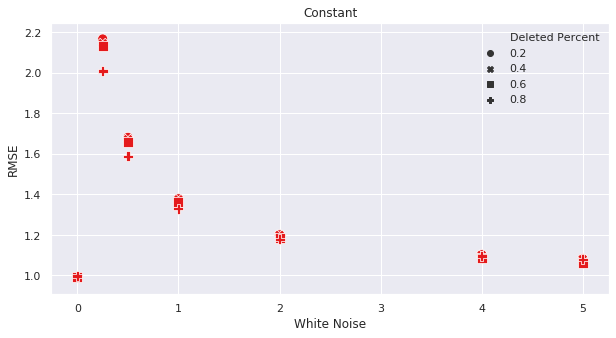

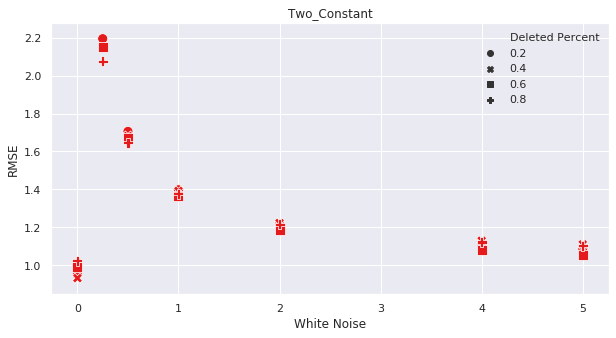

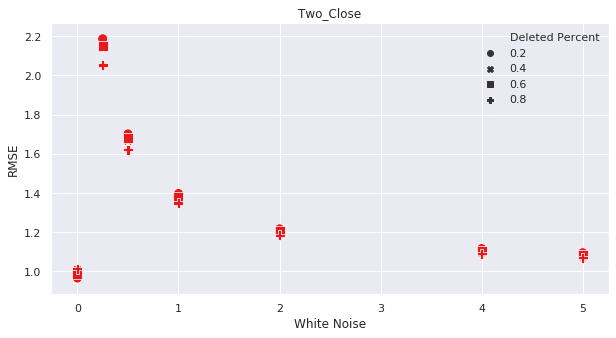

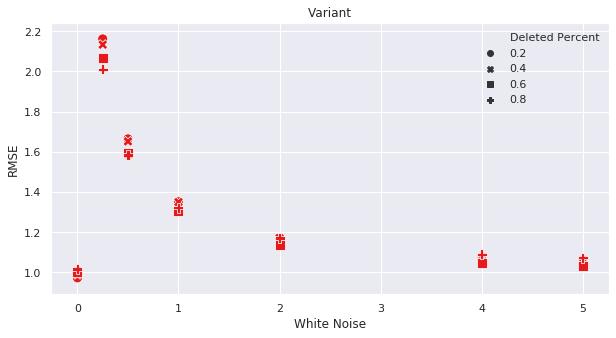

In [158]:
for freq in freq_bin:
    df_freq = result_bin.loc[result_bin['Frequency']==freq]
    plt.figure(figsize=(10,5))
    plt.title(freq)
    sns.set(style="darkgrid")
            
    sns.set_palette("Set1",3)
    plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    
    sns.scatterplot(x='White Noise',y='RMSE',data=df_freq,s=100,cmap='Accent',style='Deleted Percent')
    